In [1]:
### Author: Leonie Küchenhoff
### Date: October 2022
### Purpose of script: Calculate fraction of SNP per sample and categorize into type of SNP
###                     + Plot results

In [2]:
# package import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from config import basedir, outdir
from itertools import product

In [3]:
# plot paraneters
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

In [ ]:
# info for directories
os.chdir(basedir)
outdir = str(outdir + '/SNP_type/')
print('This base directory will be used:\n', basedir)  
os.chdir(basedir)

In [5]:
# define sample names
names = ['028_pbs_R', '029_pbs_R', '032_pbs_R','033_nrch_R', '030_nrch_R', '036_nrch_R', 
            '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
base_editor = ['pbs', 'pbs', 'pbs','8e-NRCH', '8e-NRCH', '8e-NRCH',
            'pbs', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'pbs', 'pbs', 'max-SpRY', 'max-SpRY']
varcallers = ['hc', 'pl', 'st']
mutation = ['R636Q' if i[-1] == 'R' else 'P635L' for i in names]
combinations = list(product(names, varcallers))
# columns with AD values
col1 = 'ad_h'
col2 = 'ad_l'
condition = [i+'_'+j for i,j in zip(base_editor, mutation)]

In [6]:
# paths to input files
paths_t_spec = [f'filtered_tables/HL{i}.specific.annofilter.txt' for i in names]

In [7]:
# read in data and save in dictionary format for easy accessing throughout the script
t_specific_dict = {}
germline_dict = {}
for i in zip(paths_t_spec, names):
    t_spec = pd.read_csv(i[0], delimiter = '\t')
    t_spec = t_spec[(t_spec['chr'] != 'chrX') & (t_spec['chr'] != 'chrY')]
    t_specific_dict[i[1]] = t_spec

In [8]:
def get_snp(df):
    '''
    function to extract all variants that are snps 
    (both reference and alternative are of length 1)
    input: variant df with ref and alt column
    output: variant df with all columns with snp
    '''
    ref = df['ref'].str.len()
    alt = df['alt'].str.len()
    snp = ((ref == 1) & (alt == 1))
    snp_df = df[snp]
    return snp_df

In [9]:
def categorize(df, col):
    '''
    categorizes df into three categories (low, medium & high) based on column values
    adds category as tier column to df (tier 0,1,2)
    '''
    df['percentile'] = df[col].rank(pct = True)
    conditions = [
        (df['percentile']<= 1/3),
        ((df['percentile']> 1/3) & (df['percentile']<= 2/3)),
        (df['percentile']> 2/3)
        ]
    # create a list of the values we want to assign for each condition
    values = ['0', '1', '2']

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['tier'] = np.select(conditions, values)

    return df


In [10]:
def snp_stats_table_strand_group(df):
    '''
    function to get the summary statistics on which snps
    were measured how many times. Separates strands into + and - based on annotation of region.
    Is thereore able to distinguish e-g ac C>A from a G>T mutation
    '''
    df_c = df.copy()
    df_c.loc[:,'replacement'] = df_c['ref'] + df_c['alt']

    # for all negative strand annotated variants, reverse annotation
    rev = df_c[df_c['strand'] == '-']
    # group each snp with its reverse snp
    rev.loc[rev['replacement'] == 'GA', 'replacement'] = 'CT'
    rev.loc[rev['replacement'] == 'GT', 'replacement'] = 'CA'
    rev.loc[rev['replacement'] == 'GC', 'replacement'] = 'CG'
    rev.loc[rev['replacement'] == 'AT', 'replacement'] = 'TA'
    rev.loc[rev['replacement'] == 'AG', 'replacement'] = 'TC'
    rev.loc[rev['replacement'] == 'AC', 'replacement'] = 'TG'
    rev.loc[rev['replacement'] == 'CT', 'replacement'] = 'GA'
    rev.loc[rev['replacement'] == 'CA', 'replacement'] = 'GT'
    rev.loc[rev['replacement'] == 'CG', 'replacement'] = 'GC'
    rev.loc[rev['replacement'] == 'TA', 'replacement'] = 'AT'
    rev.loc[rev['replacement'] == 'TC', 'replacement'] = 'AG'
    rev.loc[rev['replacement'] == 'TG', 'replacement'] = 'AC'


    df_c[df_c['strand'] == '-'] = rev
     

    # count snps in heart per sample 
    heart_spec = df_c[df_c['heart']]    
    heart_spec = categorize(heart_spec[heart_spec['heart']], 'normed_h')

    heartcount = heart_spec.groupby(['tier','replacement'], as_index = False).count()[['tier','replacement','heart']]

    heartcount['fractions_all'] = heartcount['heart'] / heartcount['heart'].sum()
    heartcount['fraction_per_tier'] = heartcount['heart'] / heartcount.groupby('tier')['heart'].transform('sum')
    all_fractions = heartcount.groupby('replacement').sum()

    return all_fractions, heartcount

In [11]:
def snp_stats_table_group(df):
    '''
    function to get the summary statistics on which snps
    were measured how many times.
    '''

    df_c = df.copy()
    #get one filed with ref and alt for easier handling
    df_c.loc[:,'replacement'] = df_c['ref'] + df_c['alt']

    # group each snp with its reverse snp
    df_c.loc[df_c['replacement'] == 'GA', 'replacement'] = 'CT'
    df_c.loc[df_c['replacement'] == 'GT', 'replacement'] = 'CA'
    df_c.loc[df_c['replacement'] == 'GC', 'replacement'] = 'CG'
    df_c.loc[df_c['replacement'] == 'AT', 'replacement'] = 'TA'
    df_c.loc[df_c['replacement'] == 'AG', 'replacement'] = 'TC'
    df_c.loc[df_c['replacement'] == 'AC', 'replacement'] = 'TG'


    df_c.loc[df_c['replacement'] == 'CA', 'replacement']= f'C>A\nG>T'
    df_c.loc[df_c['replacement'] == 'CG', 'replacement']= f'C>G\nG>C'
    df_c.loc[df_c['replacement'] == 'CT', 'replacement']= f'C>T\nG>A'
    df_c.loc[df_c['replacement'] == 'TA', 'replacement']= f'T>A\nA>T'
    df_c.loc[df_c['replacement'] == 'TC', 'replacement']= f'T>C\nA>G'
    df_c.loc[df_c['replacement'] == 'TG', 'replacement']= f'T>G\nA>C'


    # count snps in heart per sample 
    heart_spec = df_c[df_c['heart']]
    liver_spec = df_c[df_c['liver']]

    heart_spec = categorize(heart_spec[heart_spec['heart']], 'normed_h')
    heartcount = heart_spec.groupby(['tier','replacement'], as_index = False).count()[['tier','replacement','heart']]

    heartcount['fractions_all'] = heartcount['heart'] / heartcount['heart'].sum()
    heartcount['fraction_per_tier'] = heartcount['heart'] / heartcount.groupby('tier')['heart'].transform('sum')
    all_fractions = heartcount.groupby('replacement').sum()


    return all_fractions, heartcount, heart_spec

In [12]:
# calculate fractions and store results in shape of dictionary
snp_dict = {}
all_fractions_dict = {}
group_fractions_dict = {}
for count,i in enumerate(names):
    snp_dict[f'{i}_t_spec'] = get_snp(t_specific_dict[i])
    all_fractions_dict[i], group_fractions_dict[i], heart_spec= snp_stats_table_group(snp_dict[f'{i}_t_spec'])
    all_fractions_dict[i]['sample'] = condition[count]
    group_fractions_dict[i]['sample'] = condition[count]
    all_fractions_dict[i]=all_fractions_dict[i].fillna(0)
fractions_stats = pd.concat([all_fractions_dict[i] for i in names])
plot = fractions_stats#[fractions_stats['variable']=='heart']
fractions_stats_group = pd.concat([group_fractions_dict[i] for i in names])


In [13]:
# calculate fractions and store results in shape of dictionary with strand specific info
snp_dict_strand = {}
all_fractions_dict_strand = {}
group_fractions_dict_strand = {}
for count,i in enumerate(names):
    snp_dict_strand[f'{i}_t_spec'] = get_snp(t_specific_dict[i])
    all_fractions_dict_strand[i], group_fractions_dict_strand[i] = snp_stats_table_strand_group(snp_dict_strand[f'{i}_t_spec'])
    all_fractions_dict_strand[i]['sample'] = condition[count]
    group_fractions_dict_strand[i]['sample'] = condition[count]
    all_fractions_dict_strand[i]=all_fractions_dict_strand[i].fillna(0)
fractions_stats_strand = pd.concat([all_fractions_dict_strand[i] for i in names])
plot_strand = fractions_stats_strand#[fractions_stats_strand['variable']=='heart']
fractions_stats_strand_group = pd.concat([group_fractions_dict_strand[i] for i in names])

In [14]:
#costum color palette
colors = ['bisque',
          'orange',
          'azure',
          'steelblue',
          'navy'
          ]
costum_palette = sns.color_palette(colors)

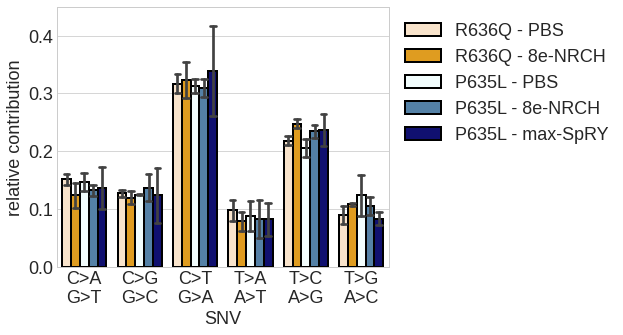

In [16]:
# Plot samples in one plot
fig, ax = plt.subplots(1,1, figsize = (9,5), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x = plot.index,y = 'fractions_all', hue = 'sample', data = plot, capsize = 0.1,ci ='sd', 
            palette = costum_palette, edgecolor = 'black', linewidth = 2)


ax.set_xlabel('SNV')
ax.set_ylabel('relative contribution')

ax.set_ylim(0,0.45)

L = ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left')

L.get_texts()[0].set_text('R636Q - PBS')
L.get_texts()[1].set_text('R636Q - 8e-NRCH')
L.get_texts()[2].set_text('P635L - PBS')
L.get_texts()[3].set_text('P635L - 8e-NRCH')
L.get_texts()[4].set_text('P635L - max-SpRY')
fig.tight_layout()
fig.savefig(f'{outdir}/distribution_noxy.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/distribution_noxy.svg', bbox_inches = 'tight')
plt.show()

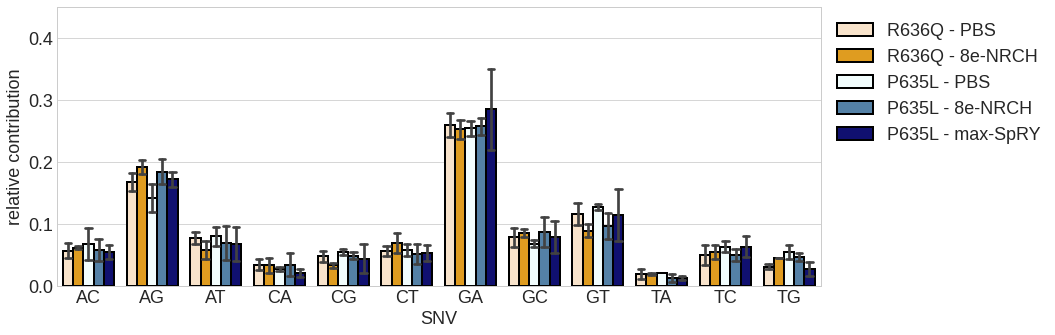

In [18]:
# Plot samples in one plot with divided strand
fig, ax = plt.subplots(1,1, figsize = (15,5), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x = plot_strand.index,y = 'fractions_all', hue = 'sample', data = plot_strand, capsize = 0.1, ci = 'sd', 
            palette = costum_palette, edgecolor = 'black', linewidth = 2)


ax.set_xlabel('SNV')
ax.set_ylabel('relative contribution')

ax.set_ylim(0,0.45)

L = ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left')

L.get_texts()[0].set_text('R636Q - PBS')
L.get_texts()[1].set_text('R636Q - 8e-NRCH')
L.get_texts()[2].set_text('P635L - PBS')
L.get_texts()[3].set_text('P635L - 8e-NRCH')
L.get_texts()[4].set_text('P635L - max-SpRY')
fig.tight_layout()
fig.savefig(f'{outdir}/distribution_noxy_strand.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/distribution_noxy_strand.svg', bbox_inches = 'tight')
plt.show()


Save data to txt files

In [20]:
save = {}
for i in names:
    save[i] = group_fractions_dict[i].rename(columns = {'heart':i}).iloc[:,0:3]

In [21]:
merged_save = save[names[0]].merge(
    save[names[1]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[2]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[3]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[4]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[5]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[6]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[7]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[8]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[9]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[10]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[11]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[12]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[13]], on = ['replacement', 'tier'], how = 'outer').merge(
    save[names[14]], on = ['replacement', 'tier'], how = 'outer')

In [22]:
merged_save.to_csv(f'{outdir}/tier.txt')
merged_save.groupby('replacement').sum().to_csv(f'{outdir}/grouped.txt')


In [23]:
save_strand = {}
for i in names:
    save_strand[i] = group_fractions_dict_strand[i].rename(columns = {'heart':i}).iloc[:,0:3]

In [24]:
merged_save_strand = save_strand[names[0]].merge(
    save_strand[names[1]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[2]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[3]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[4]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[5]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[6]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[7]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[8]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[9]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[10]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[11]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[12]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[13]], on = ['replacement', 'tier'], how = 'outer').merge(
    save_strand[names[14]], on = ['replacement', 'tier'], how = 'outer')

In [26]:
merged_save_strand.to_csv(f'{outdir}/strand_tier.txt')
merged_save_strand.groupby('replacement').sum().to_csv(f'{outdir}/strand.txt')